# 1. Import các thư viện, module:

In [31]:
import pandas as pd
import numpy as np
import datetime as dt

import requests
import json

# Trong đó:
+ pandas: là một thư viện Python toàn diện; một nguồn lực để thực hiện phân tích và thao tác dữ liệu; bất kỳ loại xử lý, phân tích, lọc và tổng hợp dữ liệu nào.
+ numpy: là một thư viện trong Python mã nguồn mở chủ yếu được sử dụng để thao tác và xử lý dữ liệu dưới dạng mảng.
+ datetime: là Module cung cấp các hàm xử lý ngày, thời gian và khoảng thời gian.
+ requests: là một thư viện HTTP đơn giản dành cho python, về cơ bản nó sử dụng để gửi yêu cầu đến API.
+ json (JavaScript Object Notation): thư viện sử dụng để làm việc với dữ liệu JSON.

# 2. Crawl dữ liệu về lịch sử giao dịch từ SSI Iboard:

In [32]:

def data_from_tradingview(symbol):
    # Trích đường dẫn trang web SSI Iboard
    trading_view_data_url = 'https://iboard.ssi.com.vn/dchart/api/history'
    # Tạo một giao diện gồm các đề mục bao gồm ngày/tháng/năm, giá mở cửa, giá cao nhất, giá thấp nhất, giá đóng cửa, khối lượng giao dịch:
    data_json = {
        'date': [],
        'open': [],
        'high': [],
        'low': [],
        'close': [],
        'volume': [],
    }
# Xác định rõ thời điểm hiện tại qua thư viện datetime:
    now = dt.datetime.now()
# Trích ra số năm hiện tại (2022):
    current_year = now.year
# Thực hiện tạo một vòng lặp lấy dữ liệu qua hằng năm từ SSI Iboard, bắt đầu từ năm 2000 đến năm 2022:
    for year in range(2000, current_year+1):
        # Thiết lập lấy dữ liệu từ ngày 1/1 đến ngày 31/12 mỗi năm:
        begin_date = int(dt.datetime(year, 1, 1).timestamp())
        end_date = int(dt.datetime(year, 12, 31).timestamp())
        # Dùng thư viện requests gửi yêu cầu đến API nhằm truy xuất và lấy dữ liệu từ SSI Iboard:
        response = requests.get(
            f'{trading_view_data_url}?symbol={symbol}&resolution=D&from={begin_date}&to={end_date}')
# Chuyển đổi dữ liệu phản hồi và gán các ký tự tượng trưng cho từng chuỗi dữ liệu vào các đề mục đã tạo:
        response_data = json.loads(response.text)
        data_json['date'].extend(response_data['t'])
        data_json['open'].extend(response_data['o'])
        data_json['high'].extend(response_data['h'])
        data_json['low'].extend(response_data['l'])
        data_json['close'].extend(response_data['c'])
        data_json['volume'].extend(response_data['v'])

# Dữ liệu chưa được định dạng nên định dạng dữ liệu thành dạng float (dạng số):
    df = pd.DataFrame(data_json)
    df= df.mask(df == '')
    df = df.astype(float)
# Xác định ngày/tháng/năm vào cột date qua module datetime và sắp xếp cột date theo thứ tự đồng thời kiểm tra sự trùng lặp:
    df['date'] = pd.to_datetime(df['date'], unit='s')
    df = df.set_index('date').sort_index()
    df = df.loc[~df.index.duplicated(keep='first')]
    return df


# 3. Tạo bảng dữ liệu cho hai mã cổ phiểu VND và SSI:

In [33]:
# Cấu hình các mã cổ phiếu (symbol) để trực quan hóa:
symbol_list = ['VND','SSI']
# Truy xuất danh sách dữ liệu VND và SSI:
historical_data_list = []
for symbol in symbol_list:
    stock_historical_data = data_from_tradingview(symbol)
    historical_data_list.append(stock_historical_data)
# Thực hiện đưa danh sách chuỗi dữ liệu VND và SSI vào bảng dữ liệu:
historical_data_frame = pd.concat(historical_data_list, axis=1, keys=symbol_list)
# Gán tên Symbol cho hai mã VND và SSI, Historical_Data cho các đề mục:
historical_data_frame.columns.names = ['Symbol','Historical_Data']
# Kết quả:
historical_data_frame

Symbol             VND                                     SSI                \
Historical_Data   open   high    low  close      volume   open   high    low   
date                                                                           
2006-12-15         NaN    NaN    NaN    NaN         NaN   7.66  21.90   0.01   
2006-12-18         NaN    NaN    NaN    NaN         NaN   9.31   9.98   9.31   
2006-12-19         NaN    NaN    NaN    NaN         NaN  10.68  10.81   9.91   
2006-12-20         NaN    NaN    NaN    NaN         NaN  11.84  11.84  10.73   
2006-12-21         NaN    NaN    NaN    NaN         NaN  10.95  10.95  10.28   
...                ...    ...    ...    ...         ...    ...    ...    ...   
2022-12-23       14.50  14.50  13.90  14.00  20229500.0  19.00  19.10  18.25   
2022-12-26       13.85  14.00  13.05  13.05  28499900.0  18.20  18.30  17.05   
2022-12-27       13.00  13.95  13.00  13.95  22800600.0  17.00  18.20  17.00   
2022-12-28       14.10  14.35  13.70  14.10  15800300.0  18.45  18.45  17.80   
2022-12-29       13.95  14.15  13.50  13.50  13180200.0  18.00  18.25  17.60   

Symbol                              
Historical_Data  close      volume  
date                                
2006-12-15        9.98    293000.0  
2006-12-18        9.31    340200.0  
2006-12-19       10.68    326900.0  
2006-12-20       10.73    651600.0  
2006-12-21       10.28    200100.0  
...                ...         ...  
2022-12-23       18.30  11363200.0  
2022-12-26       17.05  18630300.0  
2022-12-27       18.20  14748000.0  
2022-12-28       18.15  10979500.0  
2022-12-29       17.60   8747600.0  

[3969 rows x 10 columns]

# 4. Import các module, package để vẽ biểu đồ:

In [34]:
import plotly.graph_objects as go
import ta
from plotly.subplots import make_subplots
import plotly.express as px

import seaborn as sns
import matplotlib.pyplot as plt

# Trong đó:
+ plotly.graph_objects: một module quan trọng chứa tất cả định nghĩa giúp xây dựng nên một mô hình, biểu đồ.
+ ta: một module dùng đễ thực hiện những phân tích kỹ thuật cho các dữ liệu chuỗi thời gian cổ phiếu.
+ plotly.subplots: module giúp trình bày nhiều dạng biểu đồ khác nhau trên cùng một cửa sổ.
+ make_subplots: giúp vẽ biểu đồ.
+ plotly.express: module chịu trách nhiệm quy định kiểu biểu đồ (đường gấp khúc, phân tán,…), trục x,y…
+ seaborn: một thư viện được xây dựng nhằm mục đích tạo ra các hình ảnh trực quan đẹp mắt.
+ matplotlib.pyplot: module giúp thiết kế và thay đổi biểu đồ.

# 5. Vẽ biểu đồ lịch sử giao dịch và đường trung bình trượt cho hai mã cổ phiếu VND, SSI:

In [35]:
for stock in symbol_list:
    # Tạo một cửa sổ gồm 2 biểu đồ và dùng chung trục x sử dụng thư viện Plotly nhằm hỗ trợ tương tác và thay đổi biểu đồ:
    fig = make_subplots(rows=2, cols=1,
                        shared_xaxes=True,
                        vertical_spacing=0.03,
                        row_width=[0.2, 0.7]
                        )
    # Truy xuất dữ liệu lịch sử giao dịch lần lượt từng mã cổ phiếu:
    specific_data = pd.DataFrame(historical_data_frame[stock])
    # Thực hiện xóa bỏ dữ liệu trống (NaN) bằng lệnh dropna:
    specific_data = specific_data.dropna()
    # Tính toán trung bình trượt cho khoảng thời gian 20, 50 và 100 ngày qua module ta:
    specific_data["MA20"] = ta.trend.sma_indicator(specific_data['close'], window=20)
    specific_data["MA50"] = ta.trend.sma_indicator(specific_data['close'], window=50)
    specific_data["MA100"] = ta.trend.sma_indicator(specific_data['close'], window=100)
    # Thực hiện thiết kế, vẽ đường trung bình trượt MA20, MA50, MA100 vào cửa sổ:
    fig.add_trace(go.Scatter(x=specific_data.index, y=specific_data['MA20'], name="MA20",line=dict(color = 'orange',width=0.5)))
    fig.add_trace(go.Scatter(x=specific_data.index, y=specific_data['MA50'], name="MA50",line=dict(color = 'black',width=0.5)))
    fig.add_trace(go.Scatter(x=specific_data.index, y=specific_data['MA100'], name="MA100",line=dict(color = 'blue',width=0.5)))
    # Thực hiện crawl dữ liệu có trong từng mã cổ phiếu và vẽ thêm đường biểu đồ nến qua lệnh Candlestick vào cửa sổ chung với đường MA:
    fig.add_trace(go.Candlestick(x=specific_data.index,
                                 open=specific_data['open'],
                                 high=specific_data['high'],
                                 low=specific_data['low'],
                                 close=specific_data['close'], name=stock),
                  row=1, col=1)
    # Thêm biểu đồ đường khối lượng giao dịch qua lệnh Bar vào cửa sổ:
    fig.add_trace(go.Bar(
        x=specific_data.index, y=specific_data['volume'], showlegend=False,marker=dict(color='blue'),opacity=1), row=2, col=1)

    # Xóa thanh trượt khoảng thời gian:
    fig.update(layout_xaxis_rangeslider_visible=False)
    # Thêm tên biểu đồ và căn chỉnh kích thước:
    fig.update_layout(
        autosize=False,
        width=780,
        height=540,
        title_text=stock+'\'S HISTORICAL TRADING DATA CHART'
    )
    # Kết quả:
    fig.show()

# Ở bảng kết quả:
+ Biểu đồ nến trên cho thấy biến động về giá mở cửa, giá cao nhất, giá thấp nhất, giá đóng cửa của hai mã cổ phiếu VND và SSi trong một phiên giao dịch. Màu xanh cho thấy rằng giá ở phiên sau tăng so với phiên trước và màu đỏ thì ngược lại. Từ biểu đồ ta thấy cả hai mã cổ phiếu đều đang có xu hướng giảm.
+ Ba đường trung bình trượt được tính dựa trên giá đóng cửa và được lấy trong ba khoảng thời gian khác nhau là 20, 50 và 100 ngày.
+ Biểu đồ phía dưới cho thấy biến động trong khối lượng giao dịch của hai mã cổ phiếu

Để biết được dữ liệu phân bố như thế nào, ta sử dụng “box plot”:

<AxesSubplot: xlabel='Symbol'>

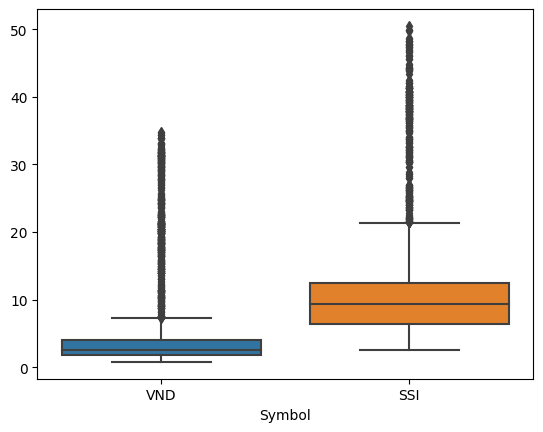

In [36]:
#draw boxplot of symbols
sns.boxplot(historical_data_frame.xs(key='close',axis=1,level='Historical_Data'))

Nhìn vào biểu đồ hộp và râu của VND và SSI ta thấy:
- Có dữ liệu ngoại lai (outliers - giá cao hơn so với phân bố trung bình) lớn
- Nhìn chung giá của SSI cao hơn so với VND
- Mật độ dữ liệu tập trung cao ở phần nửa dưới, tập dữ liệu không đối xứng
- Tập dữ liệu phân phối không đều

## **SO SÁNH PHẦN TRĂM THAY ĐỔI GIÁ CỦA CÁC MÃ CỔ PHIẾU VỚI CHỈ SỐ VNINDEX**

In [37]:
#Lấy dữ liệu lịch sử của "VNINDEX"
vn_index_symbol = 'VNINDEX'
vn_index_historical_data = data_from_tradingview(vn_index_symbol)

compare_symbol_list = []
compare_symbol_list.extend(symbol_list)
compare_symbol_list.append(vn_index_symbol)

#Tạo danh sách so sánh bao gồm danh sách symbol đã được cấu hình và VNINDEX
compare_data_list = []
compare_data_list.extend(historical_data_list)
compare_data_list.append(vn_index_historical_data)

# Chuyển đổi dữ liệu so sáng dạng danh sách sang dataframe để sắp xếp dữ liệu theo bảng => Xác định vị trí dữ liệu, dễ dàng gọi và thao tác cùng lúc
compare_data_frame = pd.concat(compare_data_list, axis=1, keys=compare_symbol_list)
compare_data_frame = compare_data_frame.dropna()
compare_data_frame.columns.names = ['Symbol','Historical_Data']
compare_data_frame


Symbol             VND                                     SSI                \
Historical_Data   open   high    low  close      volume   open   high    low   
date                                                                           
2010-03-30        2.94   3.06   2.77   2.87    869800.0  11.32  11.40  11.04   
2010-03-31        2.90   3.01   2.87   2.97    542900.0  10.97  11.17  10.97   
2010-04-01        2.98   3.06   2.97   3.01    372900.0  10.92  11.17  10.84   
2010-04-02        3.03   3.03   2.87   2.99    569400.0  11.15  11.30  11.04   
2010-04-05        2.94   3.08   2.87   3.08    748500.0  11.25  11.35  11.20   
...                ...    ...    ...    ...         ...    ...    ...    ...   
2022-12-23       14.50  14.50  13.90  14.00  20229500.0  19.00  19.10  18.25   
2022-12-26       13.85  14.00  13.05  13.05  28499900.0  18.20  18.30  17.05   
2022-12-27       13.00  13.95  13.00  13.95  22800600.0  17.00  18.20  17.00   
2022-12-28       14.10  14.35  13.70  14.10  15800300.0  18.45  18.45  17.80   
2022-12-29       13.95  14.15  13.50  13.50  13180200.0  18.00  18.25  17.60   

Symbol                              VNINDEX                             \
Historical_Data  close      volume     open     high      low    close   
date                                                                     
2010-03-30       11.04   1728000.0   504.71   506.29   500.72   500.72   
2010-03-31       10.97   1577570.0   501.85   504.00   499.24   499.24   
2010-04-01       11.10   1745340.0   500.37   508.91   499.99   508.18   
2010-04-02       11.15   1563440.0   510.38   512.99   508.54   510.48   
2010-04-05       11.22   1016450.0   514.17   516.27   513.45   514.79   
...                ...         ...      ...      ...      ...      ...   
2022-12-23       18.30  11363200.0  1023.69  1027.34  1013.20  1020.34   
2022-12-26       17.05  18630300.0  1019.66  1021.89   985.21   985.21   
2022-12-27       18.20  14748000.0   986.07  1007.88   983.67  1004.57   
2022-12-28       18.15  10979500.0  1008.41  1020.52   998.97  1015.66   
2022-12-29       17.60   8747600.0  1016.06  1021.96  1009.29  1009.29   

Symbol                        
Historical_Data       volume  
date                          
2010-03-30        47215800.0  
2010-03-31        45342680.0  
2010-04-01        41808032.0  
2010-04-02        39486488.0  
2010-04-05        42519132.0  
...                      ...  
2022-12-23       423823400.0  
2022-12-26       566850100.0  
2022-12-27       507189700.0  
2022-12-28       392271900.0  
2022-12-29       371300498.0  

[3162 rows x 15 columns]

In [38]:
# Tính toán phần trăm thay đổi từ ngày đầu khi các mã cổ phiếu và chỉ số VNINDEX 
# (Phải sử dụng dữ liệu của ngày mà tất cả đều bắt đầu có số liệu để các mã và chỉ số đều có chung một ngày bắt đầu)
compare_percent_change = pd.DataFrame()
for name in compare_symbol_list:
    compare_percent_change[name] = compare_data_frame[name]['close'].apply(lambda x: (x/(compare_data_frame[name]['close'][0])-1)*100)
compare_percent_change

,VND,SSI,VNINDEX
date,,,
2010-03-30,0.000000,0.000000,0.000000
2010-03-31,3.484321,-0.634058,-0.295574
2010-04-01,4.878049,0.543478,1.489855
2010-04-02,4.181185,0.996377,1.949193
2010-04-05,7.317073,1.630435,2.809954
...,...,...,...
2022-12-23,387.804878,65.760870,103.774565
2022-12-26,354.703833,54.438406,96.758668
2022-12-27,386.062718,64.855072,100.625100


In [39]:
# Crawl dữ liệu phần trăm thay đổi từ nguồn
compare_fig = make_subplots(rows=1, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.03)

for stock in compare_symbol_list:
    compare_fig.add_trace(go.Scatter(
        x=compare_percent_change[stock].index, y=compare_percent_change[stock], name=stock,line=dict(width=1)))
    
# Tắt hiển thị giới hạn phạm vi chọn giá trị 
# (Không thể chọn ngày trên trục ngang mà buộc phải thao tác trên biểu đồ để chọn khoảng thời gian muốn xem)
compare_fig.update(layout_xaxis_rangeslider_visible=False)

compare_fig.update_layout(
    autosize=False,
    width=780,
    height=540,
    title_text="Percentage Change From " + str(compare_percent_change.index[0].date())
)

compare_fig

In [40]:
# So sánh phần trăm thay đổi theo ngày của giá cổ phiếu và chỉ số VNINDEX
percent_change_by_day = pd.DataFrame()
for name in compare_symbol_list:
    percent_change_by_day[name] = compare_data_frame[name]['close'].pct_change()
percent_change_by_day

,VND,SSI,VNINDEX
date,,,
2010-03-30,NaN,NaN,NaN
2010-03-31,0.034843,-0.006341,-0.002956
2010-04-01,0.013468,0.011851,0.017907
2010-04-02,-0.006645,0.004505,0.004526
2010-04-05,0.030100,0.006278,0.008443
...,...,...,...
2022-12-23,-0.037801,-0.041885,-0.002220
2022-12-26,-0.067857,-0.068306,-0.034430
2022-12-27,0.068966,0.067449,0.019651


Dùng lệnh percent_change_by_day.info() để kiểm định dữ liệu “phần trăm thay đổi giá theo ngày” của 3 mã VND,SSI và VNINDEX:

In [41]:
percent_change_by_day.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3162 entries, 2010-03-30 to 2022-12-29
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   VND      3161 non-null   float64
 1   SSI      3161 non-null   float64
 2   VNINDEX  3161 non-null   float64
dtypes: float64(3)
memory usage: 98.8 KB


Tệp dữ liệu có 3160 giá trị, có 1 giá trị rỗng và các giá trị đều là những số thực.

Lệnh "percent_change_by_day.dropna()" để xóa hàng có giá trị rỗng trong tệp dữ liệu:

In [42]:
percent_change_by_day.dropna()

,VND,SSI,VNINDEX
date,,,
2010-03-31,0.034843,-0.006341,-0.002956
2010-04-01,0.013468,0.011851,0.017907
2010-04-02,-0.006645,0.004505,0.004526
2010-04-05,0.030100,0.006278,0.008443
2010-04-06,-0.022727,-0.013369,0.001049
...,...,...,...
2022-12-23,-0.037801,-0.041885,-0.002220
2022-12-26,-0.067857,-0.068306,-0.034430
2022-12-27,0.068966,0.067449,0.019651


Thay vì phải vẽ phân phối và đồ thị tương quan của từng cặp dữ liệu. Ở đây ta có thể đơn giản hóa bằng việc dùng "pairplot" của seaborn để vẽ đồ thị tương quan của tất cả các cặp dữ liệu trên cùng 1 bảng kết quả. 
Điều này thuận tiện hơn cho việc so sánh và đánh giá:

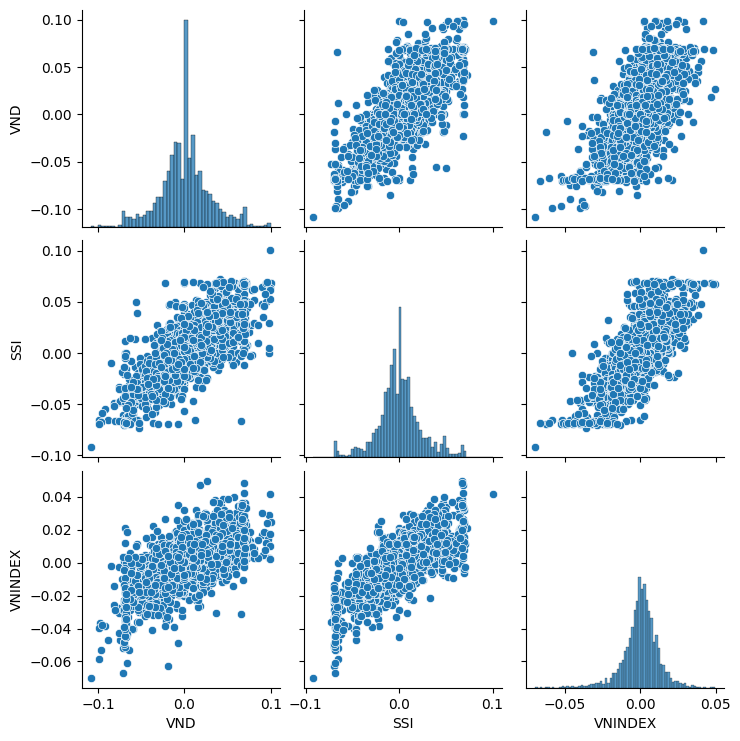

In [43]:
# crawl pairplot
sns.pairplot(percent_change_by_day)

Ở bảng kết quả:
- Nằm trên đường chéo của bảng là đồ thị phân phối của từng biến. 
- Trên và dưới của đường chéo là các đồ thị tương quan của từng cặp biến. Có thể thấy các biến đều gần như nằm gần trên 1 trục đường thẳng, do đó có thể kết luận chúng có mối tương quan và đồng biến với nhau. 
- Ngoài ra, dựa vào sự phân tán của các điểm trên biểu đồ, có thể thấy tương quan giữa các cặp dữ liệu VND-SSI, VNINDEX – SSI là khá cao.

Để kiểm tra mối tương quan một cách chính xác, ta dùng biểu đồ nhiệt “Heatmap” với “annot=true” để hiện hệ số tương quan:

<AxesSubplot: >

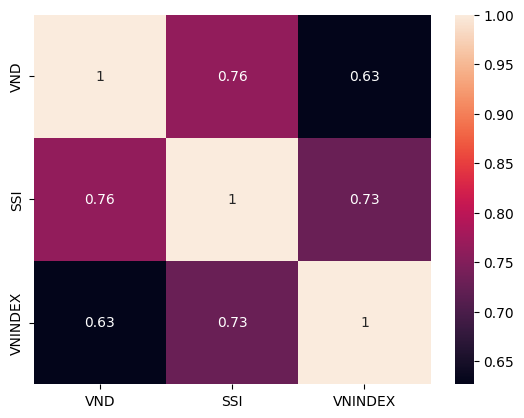

In [44]:
# crawl correlation plot
sns.heatmap(percent_change_by_day.corr(), annot=True)

Đúng như dự đoán ở trên, tương quan của VND-SSI và VNINDEX – SSI là khá cao.

Dùng Displot để tạo bảng tóm tắt về phân bố của dữ liệu một cách đầy đủ, “kde= true” để hiển thị đường cong ước tính mật độ ( Kernel density estimation – KDE): 

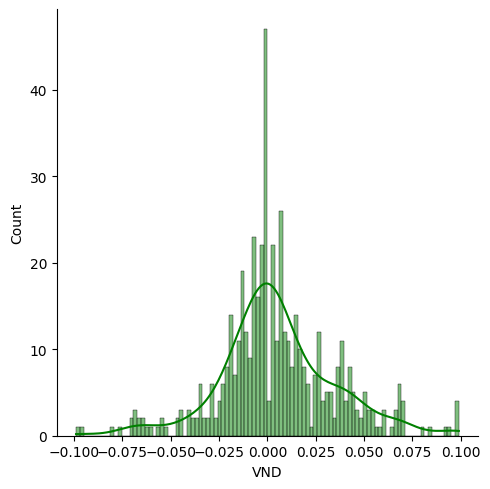

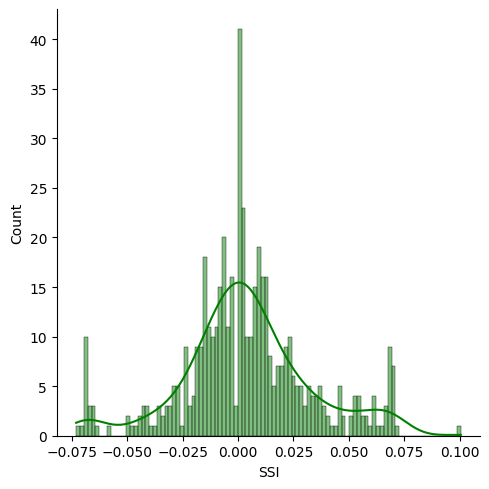

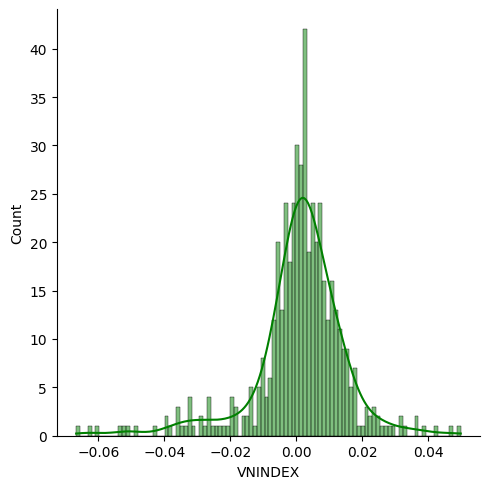

In [45]:
# thể hiện percentage change của giá chứng khoán bằng phân phối chuẩn(sửa tiếng anh dùm nha)
for stock in percent_change_by_day.columns:
    sns.displot(percent_change_by_day.loc['2020-01-01':'2021-12-31'][stock],color='green',bins=100, kde=True)

- Có thể thấy ở cả 3 biểu đồ, những giá trị ở khoảng -0.01 đến 0.01 có tần suất xuất hiện cao đột biến so với các giá trị khác.
- Ngoài ra biến động của SSI là khá lớn so với 2 dữ liệu còn lại.